## Deep Learning Final Project

### Rajesh Daravath (rd553)
### Gowtham Gangavarapu (gg386)
### TriloK Thailam (tt363)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


### Trading At The Close

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole. Almost 10% of Nasdaq’s average daily volume occurs in the closing auction. Providing true price and size discovery, the closing auction determines benchmark pricing for index funds and other investment strategies.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book trading with price auction data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

Competition Data
In this competition, Kagglers are challenged to predict the short term price movements during the 10 minute auction period. All the training data is contained within a single train.csv file. Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data & the introduction in this notebook for specific column definitions.

stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
imbalance_size - The amount unmatched at the current reference price (in USD).
imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
buy-side imbalance; 1
sell-side imbalance; -1
no imbalance; 0
reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
matched_size - The amount that can be matched at the current reference price (in USD).
far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
[bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
[bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
wap - The weighted average price in the non-auction book.
BidPrice∗AskSize+AskPrice∗BidSizeBidSize+AskSize
 
seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.
The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
Where t is the time at the current observation, we can define the target:
Target=(StockWAPt+60StockWAPt−IndexWAPt+60IndexWAPt)∗10000

## Data loading and preprocessing

**Reading the Training and Testing datasets**

In [3]:
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
test_data = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')


In [4]:
df.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [5]:
test_data.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,False


**Exploratory Data Analysis**

In [6]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

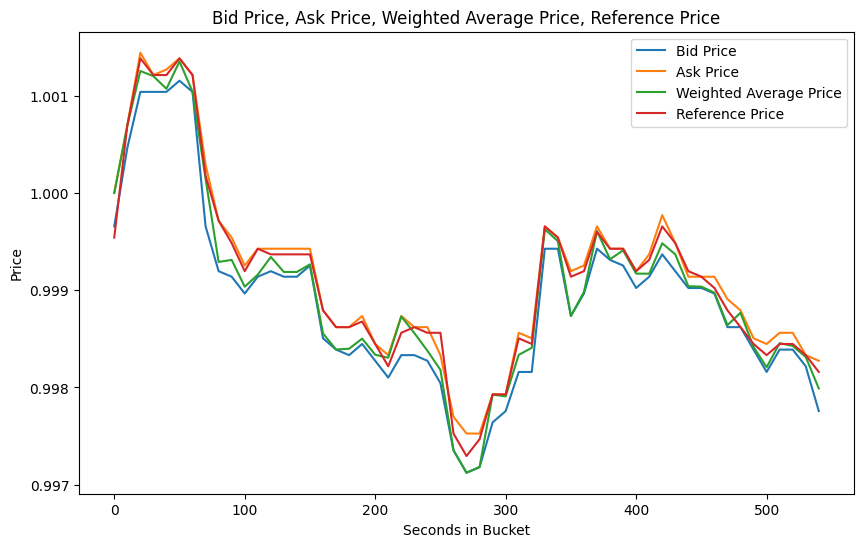

In [6]:
import matplotlib.pyplot as plt

Plot = df[(df["stock_id"] == 137) & (df["date_id"] == 0)]

plt.figure(figsize=(10, 6))
plt.plot(Plot["seconds_in_bucket"], Plot["bid_price"], label='Bid Price')
plt.plot(Plot["seconds_in_bucket"], Plot["ask_price"], label='Ask Price')
plt.plot(Plot["seconds_in_bucket"], Plot["wap"], label='Weighted Average Price')
plt.plot(Plot["seconds_in_bucket"], Plot["reference_price"], label='Reference Price')

plt.title('Bid Price, Ask Price, Weighted Average Price, Reference Price')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Price')
plt.legend()
plt.show()


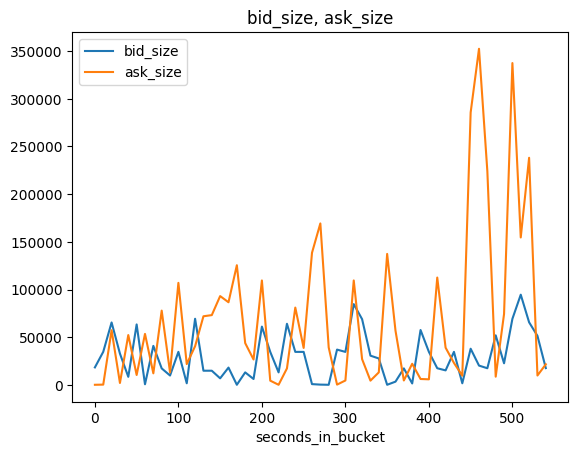

In [8]:
Plot.plot(x="seconds_in_bucket", y=["bid_size", "ask_size"])
plt.title("bid_size, ask_size")
plt.show()

In [9]:
Remove_Columns = ['stock_id', 'date_id', 'time_id', 'row_id','far_price', 'near_price']

In [10]:
df = df.drop(columns= Remove_Columns)

In [11]:
df.fillna(0, inplace = True)

In [12]:
df.head(5)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849


**Import required libraries**

In [13]:
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras import mixed_precision 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
X = df.drop(columns=['target'])

In [15]:
y = df['target']

In [16]:
y.head()

0   -3.029704
1   -5.519986
2   -8.389950
3   -4.010200
4   -7.349849
Name: target, dtype: float64

**StandardScaler is implemented to normalize the features of the dataset**

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Creating Sequences and targer as part of preparing Sequential data for RNN**

In [18]:
sequence_length = 10

sequences = []
target = []

In [19]:
for i in range(len(X_scaled) - sequence_length):
    seq = X_scaled[i:i+sequence_length]
    label = y.iloc[i+sequence_length]
    sequences.append(seq)
    target.append(label)

In [20]:
X_lstm = np.array(sequences)
y_lstm = np.array(target)


**Split the training data into train and validation datasets**

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_temporary, y_train, y_temporary = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temporary, y_temporary, test_size=0.5, random_state=42)

### LSTM 

### LSTM cell architecture

* The LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: $h_{(t)}$ and $c_{(t)}$ ("c" stands for "cell"). 

* You can think of **$h_{(t)}$** as the **short-term state** and **$c_{(t)}$** as the **long-term state**

<p align='center'>
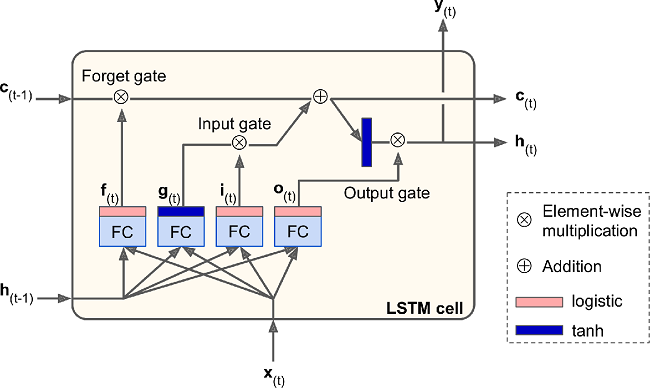
</p>


### The key idea:

* The network **can learn what to store in the long-term state, what to throw away, and what to read from it**

* As the long-term state $c_{t-1}$ traverses the network from left to right, you can see that it first goes through a **forget gate, dropping some memories,** and then it **adds some new memories** via the **addition operation** (which **adds the memories that were selected by an input gate)** The result **$c_{(t)}$ is sent straight out, without any further transformation**

* So, **at each time step, some memories are dropped and some memories are added.** Moreover, **after the addition operation,** the **long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate. This produces the short-term state $h_{(t)}$ (which is equal to the cell’s output for this time step, $y_{t}$**

### Where new memories come from and how the gates work:

First, the current input vector **$x_{(t)}$ and the previous short-term state $h_{(t-1)}$ are fed to four different fully connected layers.** They all server a diffrerent purpose:

* The **main layer** is the one that outputs **$g_{(t)}$**. It has the usual role of **analyzing** the **current inputs $x_{(t)}$** and the **previous (short term) state $h_{(t-1)}$**. In a basic cell, there is nothing other than this layer, and its **output goes straight out to $y_{(t)}$ and $h_{(t)}$** In contrast, in an LSTM cell this layer's output does not go straight out, but instead its **most important parts are stored in the long-term state** (and the rest is dropped)

* The **three other layers are gate controllers.** Since they use the **logistic activation function,** their **outputs range from 0 to 1.** As you can see, their **outputs are fed to element-wise multiplication operations,** so if they output **0s they close the gate,** and if they output **1s they open it.** Specifically:

  * The **forget gate** (controlled by **$f_{(t)}$)** controls **which parts of the long-term state should be erased**

  * The **input gate** (controlled by **$i_{(t)}$)** controls **which parts of $g_{(t)}$ should be added to the long-term state**

  * The **output gate** (controlled by **$o_{(t)}$)** controls **which parts of the long-term state should be read and output at this time step, both to $h_{(t)}$ and to $y_{(t)}$**

### Model1: In the model 1 we have used one LSTM layer with activation function as relu

In [38]:
model1 = Sequential()
model1.add(LSTM(90, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(1, activation = 'linear'))  

In [39]:
import tensorflow as tf
from tensorflow import keras
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss="mae")

In [40]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90)                36360     
                                                                 
 dense_1 (Dense)             (None, 1)                 91        
                                                                 
Total params: 36451 (142.39 KB)
Trainable params: 36451 (142.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history = model1.fit(X_train, y_train, epochs=25, batch_size=3000, validation_data=(X_val, y_val), verbose=1)


Epoch 1/25
1397/1397 [==============================] - 28s 20ms/step - loss: 6.4075 - val_loss: 6.4069
Epoch 2/25
1397/1397 [==============================] - 27s 20ms/step - loss: 6.4068 - val_loss: 6.4064
Epoch 3/25
1397/1397 [==============================] - 27s 19ms/step - loss: 6.4062 - val_loss: 6.4068
Epoch 4/25
1397/1397 [==============================] - 27s 19ms/step - loss: 6.4055 - val_loss: 6.4059
Epoch 5/25
1397/1397 [==============================] - 27s 19ms/step - loss: 6.4045 - val_loss: 6.4050
Epoch 6/25
1397/1397 [==============================] - 27s 19ms/step - loss: 6.4030 - val_loss: 6.4038
Epoch 7/25
1397/1397 [==============================] - 28s 20ms/step - loss: 6.4012 - val_loss: 6.4026
Epoch 8/25
1397/1397 [==============================] - 26s 19ms/step - loss: 6.3991 - val_loss: 6.4022
Epoch 9/25
1397/1397 [==============================] - 26s 19ms/step - loss: 6.3965 - val_loss: 6.4008
Epoch 10/25
1397/1397 [==============================] - 26s 19m

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

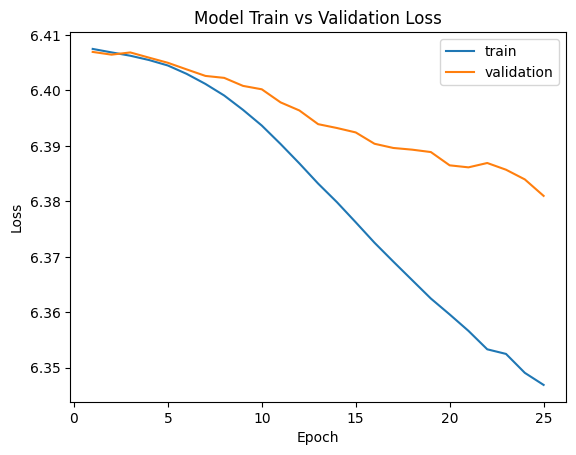

In [43]:
import seaborn as sns

sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='validation')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [44]:
y_pred1 = model1.predict(X_test)

16369/16369 [==============================] - 48s 3ms/step


In [45]:
result = model1.evaluate(X_val, y_val)

16369/16369 [==============================] - 55s 3ms/step - loss: 6.3810


In [46]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LayerNormalization

### For model2 we have used multiple layers of LSTM and also employed LayerNormalization to handle the long sequences 


In [47]:
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(LayerNormalization())
model2.add(LSTM(64, activation='relu', return_sequences=True))
model2.add(LayerNormalization())
model2.add(LSTM(32, activation='relu'))
model2.add(Dense(1))



In [48]:


model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')

In [49]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10, 100)           44400     
                                                                 
 layer_normalization (Layer  (None, 10, 100)           200       
 Normalization)                                                  
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            42240     
                                                                 
 layer_normalization_1 (Lay  (None, 10, 64)            128       
 erNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [54]:
history = model2.fit(X_train, y_train, epochs=15, batch_size=3000, validation_data=(X_val, y_val),callbacks= [early_stopping], verbose=1)

Epoch 1/15
1397/1397 [==============================] - 85s 61ms/step - loss: 6.4072 - val_loss: 6.4068
Epoch 2/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.4068 - val_loss: 6.4065
Epoch 3/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.4064 - val_loss: 6.4061
Epoch 4/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.4053 - val_loss: 6.4052
Epoch 5/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.4033 - val_loss: 6.4029
Epoch 6/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.3996 - val_loss: 6.4008
Epoch 7/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.3939 - val_loss: 6.3974
Epoch 8/15
1397/1397 [==============================] - 84s 60ms/step - loss: 6.3864 - val_loss: 6.3933
Epoch 9/15
1397/1397 [==============================] - 83s 59ms/step - loss: 6.3780 - val_loss: 6.3898
Epoch 10/15
1397/1397 [==============================] - 84s 60m

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

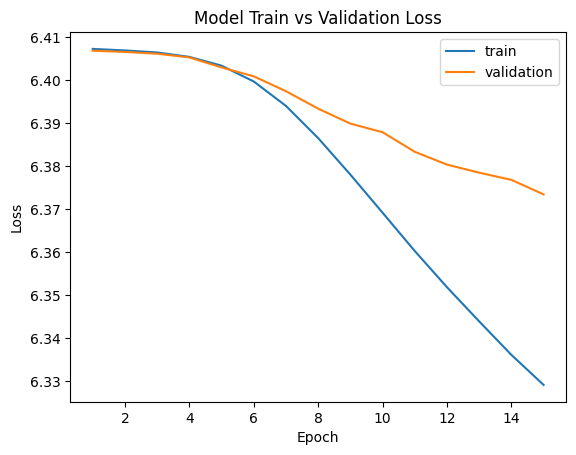

In [55]:
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='validation')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [57]:
result2 = model2.evaluate(X_val, y_val)

16369/16369 [==============================] - 102s 6ms/step - loss: 6.3733


In [56]:
y_pred2 = model2.predict(X_test)

16369/16369 [==============================] - 96s 6ms/step


In [58]:
from tensorflow import keras


In [59]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization


In [60]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GRU

## GRU

The **Gated Recurrent Unit (GRU)** cell that also introduced the Encoder-Decoder network we discuessed earlier

<p align='center'>
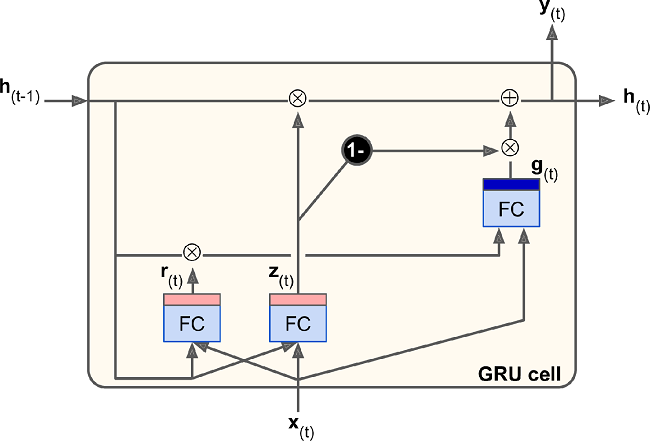
</p>

2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel)

Similarly, a **1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern** (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10- dimensional sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers) 

If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly

For example, the following model is the same as earlier, except it **starts with a 1D convolutional layer that downsamples** the input sequence by a **factor of 2,** using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to **preserve the useful information, dropping only the unimportant details.** By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns 

## Model3 we have used GRU with Convolution layer

In [61]:
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Flatten

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(MaxPooling1D(pool_size=2))
model3.add(GRU(50, activation='relu'))
model3.add(Dense(1))  



In [62]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')


In [63]:
history_model3 = model3.fit(X_train, y_train, epochs=15, batch_size=3000, validation_data=(X_val, y_val), callbacks= [early_stopping])


Epoch 1/15
1397/1397 [==============================] - 25s 16ms/step - loss: 6.4077 - val_loss: 6.4073
Epoch 2/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4069 - val_loss: 6.4068
Epoch 3/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4064 - val_loss: 6.4068
Epoch 4/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4058 - val_loss: 6.4060
Epoch 5/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4050 - val_loss: 6.4057
Epoch 6/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4042 - val_loss: 6.4059
Epoch 7/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4031 - val_loss: 6.4054
Epoch 8/15
1397/1397 [==============================] - 20s 15ms/step - loss: 6.4020 - val_loss: 6.4049
Epoch 9/15
1397/1397 [==============================] - 21s 15ms/step - loss: 6.4006 - val_loss: 6.4041
Epoch 10/15
1397/1397 [==============================] - 21s 15m

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

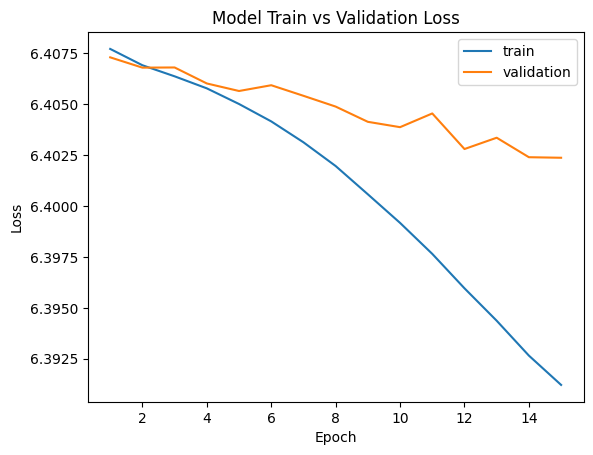

In [64]:
sns.lineplot(x=range(1, len(history_model3.history['loss']) + 1), y=history_model3.history['loss'], label='train')
sns.lineplot(x=range(1, len(history_model3.history['val_loss']) + 1), y=history_model3.history['val_loss'], label='validation')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
result3 = model3.evaluate(X_val, y_val)

16369/16369 [==============================] - 46s 3ms/step - loss: 6.4024


In [67]:
y_pred3 = model3.predict(X_test)

16369/16369 [==============================] - 39s 2ms/step


### For Model4 we have used multiple GRU layers and convolutional layers

In [27]:

model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model4.add(GRU(50, activation='relu', return_sequences=True))
model4.add(GRU(50, activation='relu'))
model4.add(Dense(1))  


In [29]:

import tensorflow as tf
from tensorflow import keras
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')




In [32]:
history_model4 = model4.fit(X_train, y_train, epochs=18, batch_size=3000, validation_data=(X_val, y_val), callbacks = [early_stopping])

Epoch 1/18
1397/1397 [==============================] - 69s 40ms/step - loss: 6.4077 - val_loss: 6.4074
Epoch 2/18
1397/1397 [==============================] - 54s 38ms/step - loss: 6.4070 - val_loss: 6.4071
Epoch 3/18
1397/1397 [==============================] - 53s 38ms/step - loss: 6.4060 - val_loss: 6.4061
Epoch 4/18
1397/1397 [==============================] - 54s 39ms/step - loss: 6.4048 - val_loss: 6.4051
Epoch 5/18
1397/1397 [==============================] - 53s 38ms/step - loss: 6.4028 - val_loss: 6.4034
Epoch 6/18
1397/1397 [==============================] - 52s 37ms/step - loss: 6.4006 - val_loss: 6.4023
Epoch 7/18
1397/1397 [==============================] - 52s 37ms/step - loss: 6.3976 - val_loss: 6.4015
Epoch 8/18
1397/1397 [==============================] - 52s 37ms/step - loss: 6.3940 - val_loss: 6.4005
Epoch 9/18
1397/1397 [==============================] - 52s 37ms/step - loss: 6.3901 - val_loss: 6.3976
Epoch 10/18
1397/1397 [==============================] - 51s 36m

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

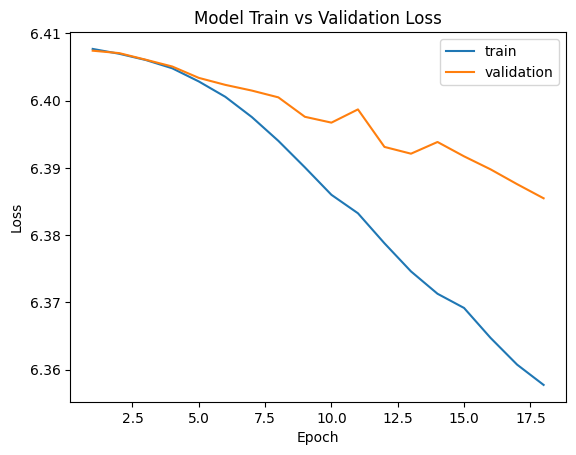

In [34]:
import seaborn as sns
sns.lineplot(x=range(1, len(history_model4.history['loss']) + 1), y=history_model4.history['loss'], label='train')
sns.lineplot(x=range(1, len(history_model4.history['val_loss']) + 1), y=history_model4.history['val_loss'], label='validation')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
y_pred4= model4.predict(X_test)

16369/16369 [==============================] - 68s 4ms/step


In [37]:
mae = mean_absolute_error(y_test, y_pred4)
print("Mean Absolute Error on Test Set:", mae)

Mean Absolute Error on Test Set: 6.375734693289744


In [68]:
result = model1.evaluate(X_val, y_val)
result2 = model2.evaluate(X_val, y_val)
result3 = model3.evaluate(X_val, y_val)
result4 = model4.evaluate(X_val, y_val)

16369/16369 [==============================] - 69s 4ms/step - loss: 6.3855
